In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

# Analytic results

Black-Scholes formula for price of an European option:

In [1]:
def Phi(z):
    """
    Cumulative of the unit normal distribution
    """
    return 0.5*(1 + erf(z/np.sqrt(2)))

def bs_price(S0, K, r, T, sigma):
    """
    Black-Scholes price of the European option
    
    Parameters
    ----------
    S0: float
        Current price of the stock
    K: float
        Strike of the option
    r: float
        Risk free interest rate (2% corresponds to 0.02)
    T: float
        Time to expiry [yr]
    sigma: float
        Implied volatility
    """
    
    # treat the limiting cases that would otherwise lead to an error
    if S0 == K:
        S0 = 1.000001*K
    if T == 0:
        T = 0.00000001
        
    d1 = (np.log(S0/K) + r*T + sigma**2*T/2) / sigma / np.sqrt(T)
    d2 = (np.log(S0/K) + r*T - sigma**2*T/2) / sigma / np.sqrt(T)
    
    return S0*Phi(d1) - K*np.exp(-r*T)*Phi(d2)

Reproduce image from Joshi: The Concepts and Practice of Mathematical Finance

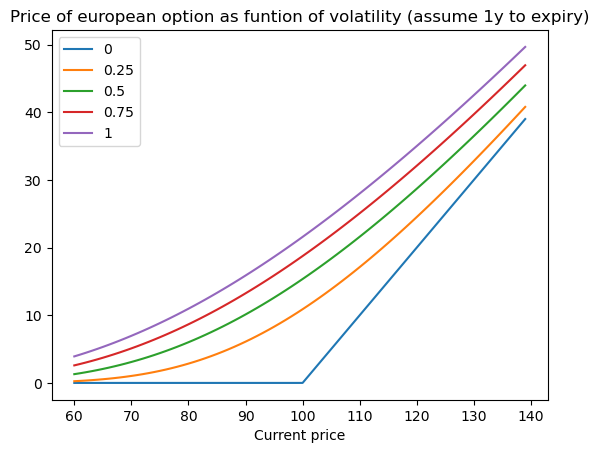

In [27]:
r = 0.00  # interest rate
T = 1     # expiry of the option [yr]
sigma = np.sqrt(0.3)  # implied volatility
K = 100   # strike

x = np.arange(60, 140, 1)
for T in [0, 0.25, 0.5, 0.75, 1]:
    y = [bs_price(xx, K, r, T, sigma) for xx in x]
    plt.plot(x, y, label = T)
plt.xlabel('Current price')
plt.title('Price of european option as funtion of volatility (assume 1y to expiry)')
plt.legend();

reproduce result from https://brilliant.org/wiki/black-scholes-merton/

In [18]:
bs_price(50, 45, 0.02, 80/365, 0.3)

6.021277654922947

# MC simulation

Simulate the underlying stochastic process and check that the analytic formula agrees with our Monte Carlo result for the option price

In [68]:
S0 = 100 
r = 0.05
T = 1 
sigma = 0.1 

def run_sims(N_iter, N_sims):
    """
    Simulate evolution of the stock price in a Black-Scholes model.
    
    Parameters
    ----------
    N_iter: integer
        Number of time steps in the model
    N_sims: integer
        Number of stock prices to simulate
    
    """
    St = S0*np.ones(N_sims)
    dT = T / N_iter

    for _ in range(N_iter):
        St *= 1 + r*dT + sigma*np.sqrt(dT)*np.random.normal(0, 1, N_sims)
        
    return St

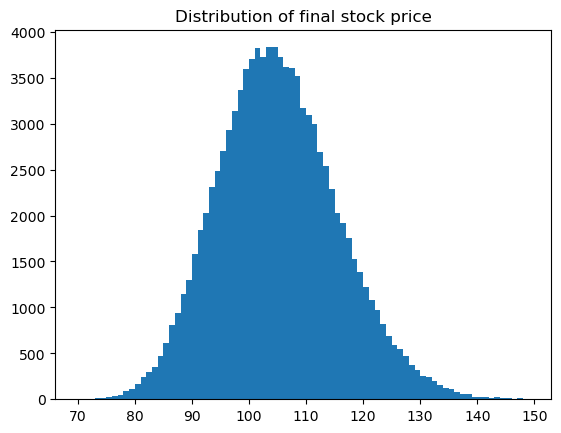

Mean and std for logarithm of the simuled stock price increase
0.04485316434300529
0.099993860450391


In [69]:
St = run_sims(3000, 100000)

plt.hist(St, np.arange(70, 150, 1)) 
plt.title('Distribution of final stock price')
plt.show()

print('Mean and std for logarithm of the simuled stock price increase')
print(np.mean(np.log(St/S0)))
print(np.std(np.log(St/S0)))

In [70]:
# Expected price of an option at various strikes using MC simulation
Ks = np.arange(60, 150, 10)

prices = []
for K in Ks:
    P = np.exp(-r*T)*(St - K)*(St >= K) # positive part of the price
    prices.append(np.mean(P))

print('Prices using direct S simulation')
print(prices)

Prices using direct S simulation
[42.911361269852115, 33.39907119002998, 23.89422257883146, 14.61409154858209, 6.798440402828038, 2.1715833453171283, 0.45756651651933583, 0.060322011020876615, 0.004860019820150784]


In [71]:
analytic = []
for K in Ks:
    analytic.append(bs_price(S0, K, r, T, sigma))

print('Analytic prices')
print(analytic)

Analytic prices
[42.9262345429456, 33.41398351977858, 23.90997789403842, 14.628837623936462, 6.805028593024943, 2.173945155462853, 0.46249651056350416, 0.06729965963705942, 0.007047187012538952]


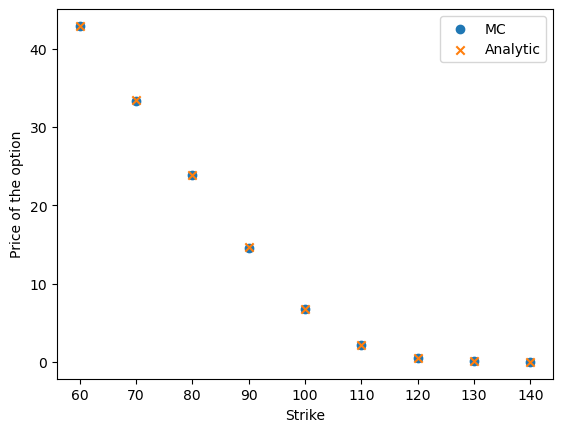

In [73]:
plt.scatter(Ks, prices, label = 'MC')
plt.scatter(Ks, analytic, marker = 'x', label = 'Analytic')
plt.xlabel('Strike')
plt.ylabel('Price of the option')
plt.legend();

We find a good agreement between the analytic formula and the MC simulation.

# Error analysis

Run the simulation several times and compare the deviation from the analytic formula with the observed scatter of results.

In [74]:
N_for_error = 40
N_iter = 3000
N_sims = 10000

mc_prices = np.zeros((N_for_error, len(Ks)))

for i in range(N_for_error):
    St = run_sims(N_iter, N_sims)
    for j, K in enumerate(Ks):
        P = np.exp(-r*T)*(St - K)*(St >= K) # positive part of the price
        mc_prices[i,j] = np.mean(P)

Means and standard deviations of the simulation prices, as a function of strike

In [75]:
means = np.mean(mc_prices, axis = 0)
stds  = np.std(mc_prices, axis = 0)

Plot the errors

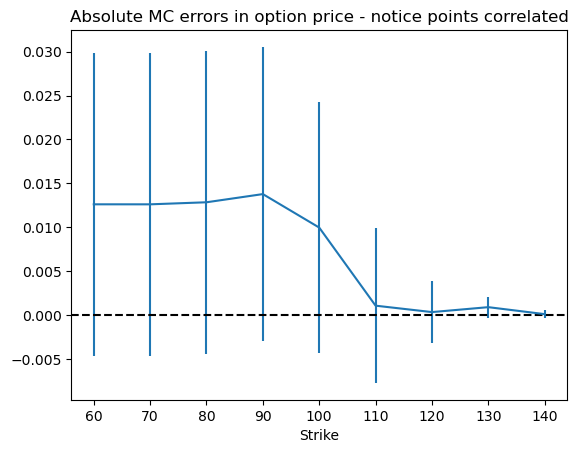

In [81]:
plt.errorbar(Ks, (analytic-means), yerr = stds/np.sqrt(N_for_error))
plt.axhline(0, c = 'k', ls = '--')
plt.title('Absolute MC errors in option price - notice points correlated');
plt.xlabel('Strike');

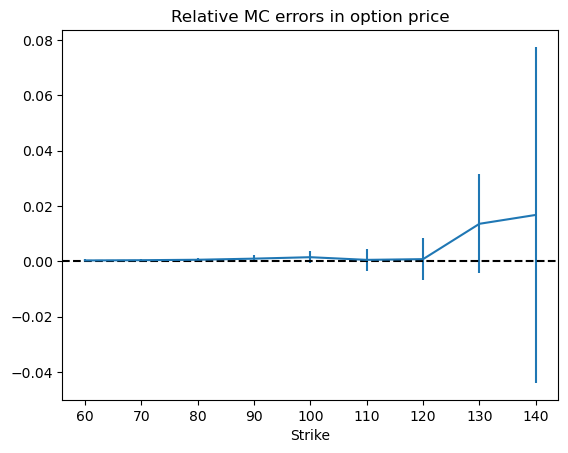

In [79]:
plt.errorbar(Ks, (analytic-means)/analytic, yerr = stds/np.sqrt(N_for_error)/analytic)
plt.axhline(0, c = 'k', ls = '--')
plt.title('Relative MC errors in option price');
plt.xlabel('Strike');

The observed errors agree with the analytic result within the error bars. The relative errors are largest at the high strikes, as expected.